# Navier Stokes 2D

$Loss = Loss_{PDE} + Loss_{IC} + Loss_{BC}$

训练的目标是：找一个函数 $f(x,y,t)=[u,v,p]$，使得这些 Loss 全都尽量小。

引入必要的库

In [1]:
import deepxde as dde
import numpy as np

Using backend: pytorch



## 1. 定义粘性系数

In [2]:
# 粘性系数
# 流体的运动粘性系数（viscosity），值越大流体越粘稠，流体越不容易流动
nu = 0.01

## 2. 定义PDE方程

In [ ]:
# PDE 残差定义
def navier_stokes(x, y):
    u = y[:, 0:1]  # 提取x方向速度，保持形状为 (N, 1)
    v = y[:, 1:2]  # 提取y方向速度
    p = y[:, 2:3]  # 提取压力

    # 计算各种偏导数
    # jacobian 函数利用自动微分技术计算偏导数
    # hessian 函数计算二阶偏导数
    u_x = dde.grad.jacobian(y, x, i=0, j=0)
    u_y = dde.grad.jacobian(y, x, i=0, j=1)
    u_t = dde.grad.jacobian(y, x, i=0, j=2)
    u_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    u_yy = dde.grad.hessian(y, x, component=0, i=1, j=1)

    v_x = dde.grad.jacobian(y, x, i=1, j=0)
    v_y = dde.grad.jacobian(y, x, i=1, j=1)
    v_t = dde.grad.jacobian(y, x, i=1, j=2)
    v_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    v_yy = dde.grad.hessian(y, x, component=1, i=1, j=1)

    p_x = dde.grad.jacobian(y, x, i=2, j=0)
    p_y = dde.grad.jacobian(y, x, i=2, j=1)

    # 定义三个方程的残差
    # eq1 和 eq2 是动量守恒方程
    # eq3 是质量守恒方程（不可压缩条件：∇·v = 0）
    eq1 = u_t + u * u_x + v * u_y + p_x - nu * (u_xx + u_yy)
    eq2 = v_t + u * v_x + v * v_y + p_y - nu * (v_xx + v_yy)
    eq3 = u_x + v_y

    # 这就是告诉 DeepXDE：
    # “请帮我最小化这个残差列表中的每一项，使它尽可能接近 0”
    # 这样，神经网络就会学习到如何满足这些方程
    return [eq1, eq2, eq3]

## 3. 定义计算域

In [ ]:
# 空间与时间定义
geom = dde.geometry.Rectangle([0, 0], [1, 1])  # 空间域：单位正方形
timedomain = dde.geometry.TimeDomain(0, 1)     # 时间域：0到1秒
geomtime = dde.geometry.GeometryXTime(geom, timedomain)  # 求解区域是这个三维立方体 (x, y, t)。

## 4. 定义初始条件

In [ ]:
# 初始条件是流体在初始时刻（t=0）的分布
# 这里设置为静止流体，即u=0, v=0, p=0
def func_u(x): return np.zeros((len(x), 1))
def func_v(x): return np.zeros((len(x), 1))
def func_p(x): return np.zeros((len(x), 1))

# dde.IC: 初始条件（Initial Condition）
# component=0/1/2 分别表示作用在 u/v/p 上
ic_u = dde.IC(geomtime, func_u, lambda _, on_initial: on_initial, component=0)
ic_v = dde.IC(geomtime, func_v, lambda _, on_initial: on_initial, component=1)
ic_p = dde.IC(geomtime, func_p, lambda _, on_initial: on_initial, component=2)

## 5. 创建数据对象
使用多少个采样点：
- 2000 个空间-时间内部点（用于最小化 PDE 残差）
- 200 个边界点（虽然你没定义边界条件，但默认仍采样）
- 200 个初始条件点
- 1000 个测试点（可视化用）

In [ ]:
# 数据集
# 使用TimePDE创建数据集
# 参数：
# - geomtime: 时空域
# - navier_stokes: 定义的PDE方程
# - [ic_u, ic_v, ic_p]: 初始条件
# - num_domain: 域内点数
# - num_boundary: 边界点数
# - num_initial: 初始点数
# - num_test: 测试点数
data = dde.data.TimePDE(
    geomtime,
    navier_stokes,
    [ic_u, ic_v, ic_p],
    num_domain=2000,
    num_boundary=200,
    num_initial=200,
    num_test=1000,
)

## 6. 构建神经网络

In [ ]:
# ignore.type: ignore
# 网络结构
"""
输入层：3个神经元（x, y, t坐标）
隐藏层：3层，每层64个神经元
输出层：3个神经元（u, v, p）
激活函数：tanh
参数初始化：Glorot uniform
"""
net = dde.nn.FNN([3] + [64] * 3 + [3], "tanh", "Glorot uniform") # type: ignore

## 7. 训练模型

Compiling model...
'compile' took 0.000562 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [6.05e-01, 7.05e-03, 1.19e-01, 7.56e-02, 1.68e-02, 8.58e-03]    [5.91e-01, 7.64e-03, 1.20e-01, 7.56e-02, 1.68e-02, 8.58e-03]    []  
1000      [9.99e-06, 7.86e-07, 4.30e-07, 1.50e-07, 1.05e-06, 5.31e-07]    [6.56e-06, 4.82e-07, 2.46e-07, 1.50e-07, 1.05e-06, 5.31e-07]    []  
2000      [1.76e-06, 4.20e-07, 1.89e-07, 8.33e-08, 5.64e-07, 2.12e-07]    [1.12e-06, 2.28e-07, 1.05e-07, 8.33e-08, 5.64e-07, 2.12e-07]    []  
3000      [2.34e-07, 1.87e-07, 1.10e-07, 4.60e-08, 3.09e-07, 1.21e-07]    [1.42e-07, 1.07e-07, 5.48e-08, 4.60e-08, 3.09e-07, 1.21e-07]    []  
4000      [1.03e-07, 8.29e-07, 7.48e-08, 2.05e-08, 1.83e-07, 1.66e-07]    [8.72e-08, 8.68e-07, 3.43e-08, 2.05e-08, 1.83e-07, 1.66e-07]    []  
5000      [6.32e-08, 6.71e-08, 4.75e-08, 1.39e-08, 1.10e-07, 4.00e-08]

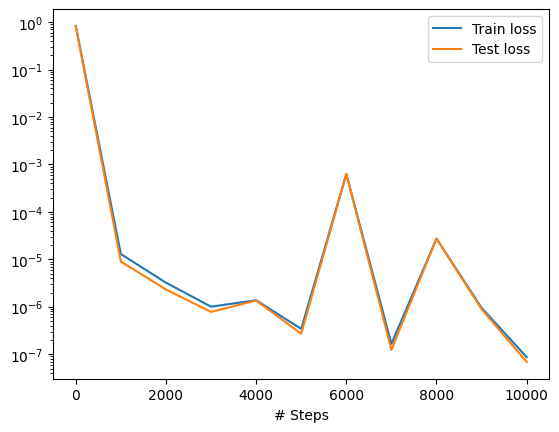

In [ ]:
# 构建模型
"""
使用Adam优化器训练10000轮，让神经网络学习满足：

PDE方程残差最小
初始条件误差最小
"""
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(epochs=10000)

# 可视化损失
dde.saveplot(losshistory, train_state, issave=False, isplot=True)